<a href="https://colab.research.google.com/github/Manojkumar310897/Flight-Fare-Prediction/blob/main/Copy_of_Flight_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the dataset**

In [3]:
df=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Data_Train.xlsx")

In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
df.shape

(10683, 11)

In [6]:
df.size

117513

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


# **DATA CLEANING**

# 1.Checking for null values

In [8]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [9]:
df=df.dropna()

# 2.Spelling Correction

In [10]:
df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [11]:
df['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [12]:
df['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [13]:
df['Destination']=df['Destination'].replace('New Delhi','Delhi')

<ipython-input-13-b95aed2e1395>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Destination']=df['Destination'].replace('New Delhi','Delhi')


In [14]:
df['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [15]:
df['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [16]:
df['Route'].value_counts()

DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: Route, Length: 128, dtype: int64

**3.Checking for Data Types**

In [17]:
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

**4.Checking for duplicates**

In [18]:
df.duplicated().sum()

220

In [19]:
df=df.drop_duplicates()

**5.Checking for outliers**

In [20]:
df.describe()

,Price
count,10462.000000
mean,9026.790289
std,4624.849541
min,1759.000000
25%,5224.000000
50%,8266.000000
75%,12344.750000
max,79512.000000


# **FEATURE ENGINEERING**

In [21]:
def duration_preprocess(value):
    lst=value.split()
    if len(lst)==2:     # if both the hours and minutes are present return it
        return value
    else:
        if 'h' in value:  # if only hour is present append 0m
            return value+' 0m'
        else:             # if only minute is present add 0h in the front
            return '0h '+value

In [22]:
df['Duration']=df['Duration'].apply(duration_preprocess)

<ipython-input-22-ca5bd92788fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Duration']=df['Duration'].apply(duration_preprocess)


In [23]:
df['duration_hours']=df['Duration'].apply(lambda x:int(x.split()[0][:-1]))
df['duration_minutes']=df['Duration'].apply(lambda x:int(x.split()[1][:-1]))

<ipython-input-23-fd24421c82a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_hours']=df['Duration'].apply(lambda x:int(x.split()[0][:-1]))
<ipython-input-23-fd24421c82a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_minutes']=df['Duration'].apply(lambda x:int(x.split()[1][:-1]))


In [24]:
df["Journey_day"] = df['Date_of_Journey'].str.split('/').str[0].astype(int)
df["Journey_month"] = df['Date_of_Journey'].str.split('/').str[1].astype(int)
df.drop(["Date_of_Journey"], axis = 1, inplace = True)

<ipython-input-24-ebba30cfb7a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Journey_day"] = df['Date_of_Journey'].str.split('/').str[0].astype(int)
<ipython-input-24-ebba30cfb7a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Journey_month"] = df['Date_of_Journey'].str.split('/').str[1].astype(int)
<ipython-input-24-ebba30cfb7a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [25]:
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df.drop(["Dep_Time"], axis = 1, inplace = True)

In [26]:
df["Arr_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arr_min"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
df.drop(["Arrival_Time"], axis = 1, inplace = True)

In [27]:
df['Journey_month'].value_counts()

5    3395
6    3311
3    2678
4    1078
Name: Journey_month, dtype: int64

In [28]:
df['Journey_day'].value_counts()

9     1375
6     1268
27    1092
21    1085
1     1058
24    1022
15     967
12     946
3      835
18     814
Name: Journey_day, dtype: int64

# **EDA**

<Axes: >

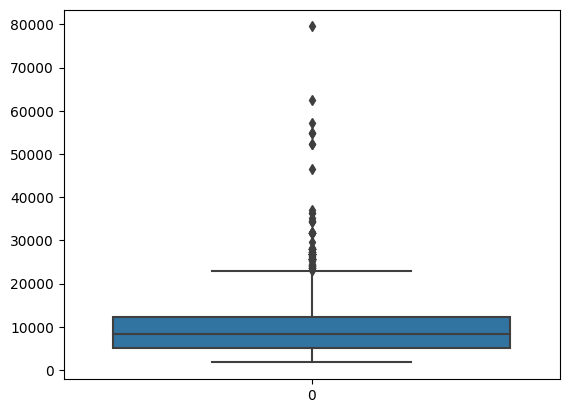

In [29]:
sns.boxplot(df['Price'])

In [30]:
print(df['Price'].skew())

1.8574899082173875


# **Univariate Analysis**

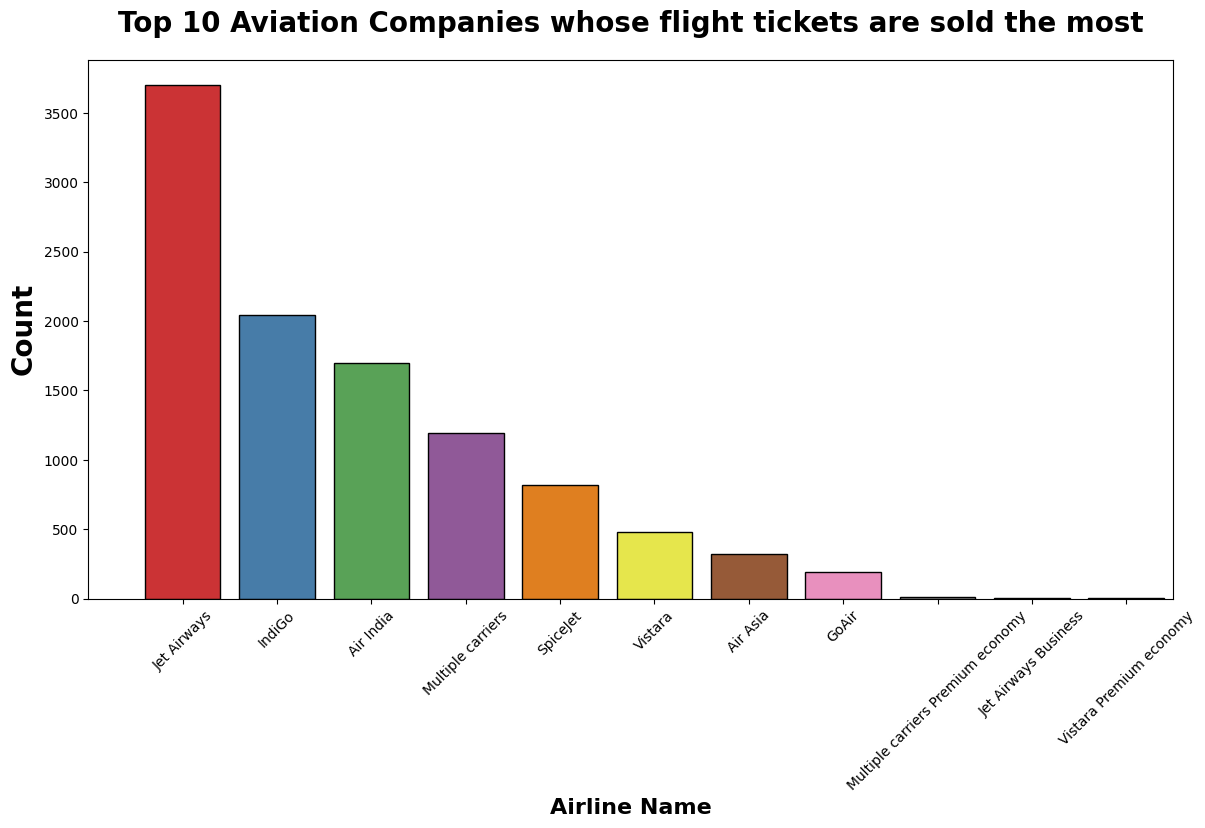

In [31]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Airline", data=df,ec = "black",palette="Set1",order = df['Airline'].value_counts().index)
plt.title("Top 10 Aviation Companies whose flight tickets are sold the most", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("Airline Name", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

According to the count plot for Airline the **Jet_Airways** is most used Airlines and **Vistara_Premium** is leaast used Airlines.

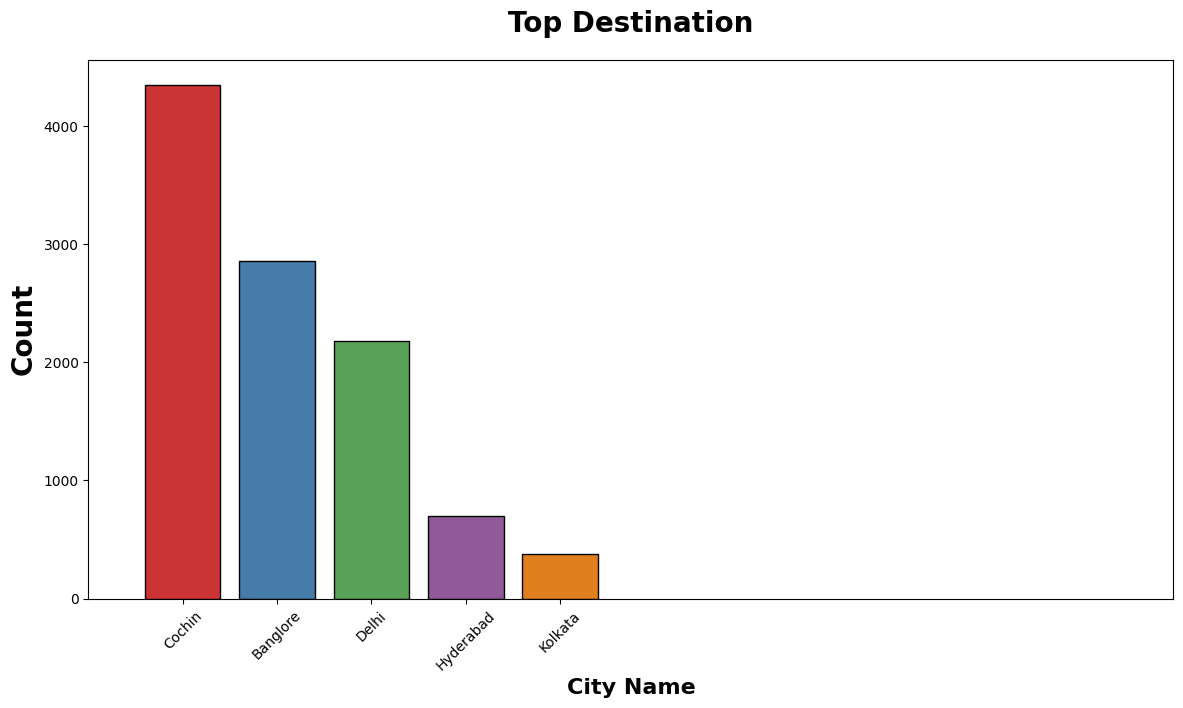

In [32]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Destination", data=df,ec = "black",palette="Set1",order = df['Destination'].value_counts().index)
plt.title("Top Destination", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("City Name", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

According to the count plot for Destination most of the Airlines have  **Cochin** as their Destination and **Kolkata** is least used Destination.

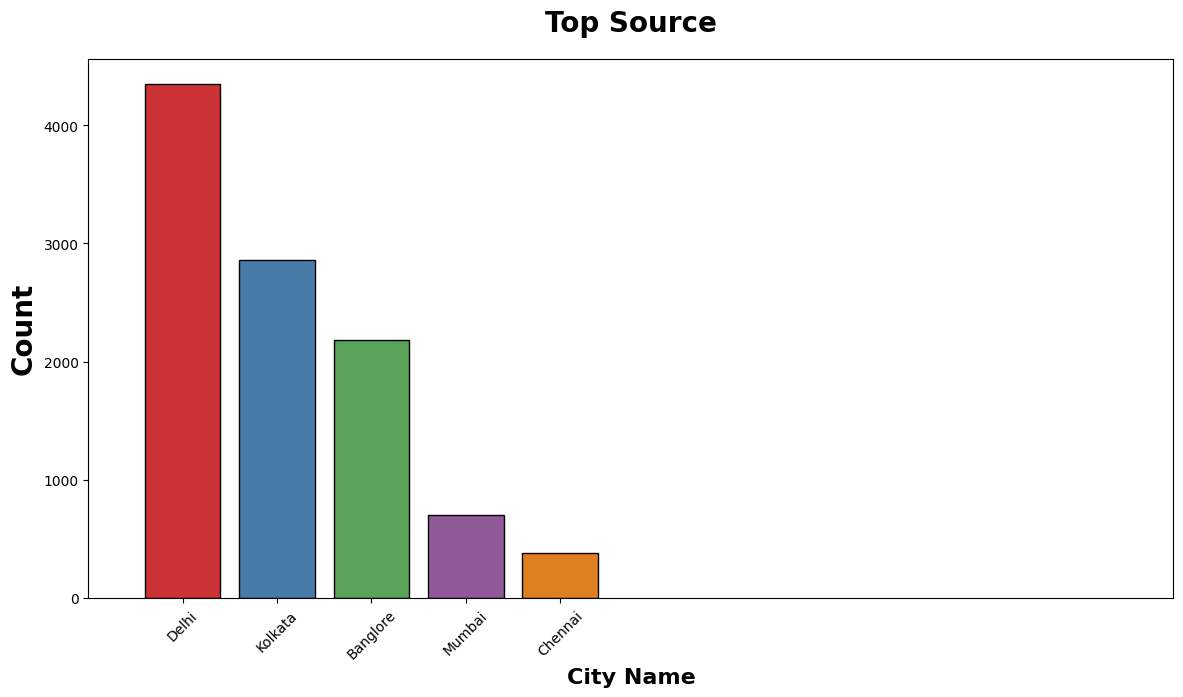

In [33]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Source", data=df,ec = "black",palette="Set1",order = df['Source'].value_counts().index)
plt.title("Top Source", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("City Name", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

According to the count plot for Source most of the Airlines have departured from **Delhi** and **Chennai **is least one.

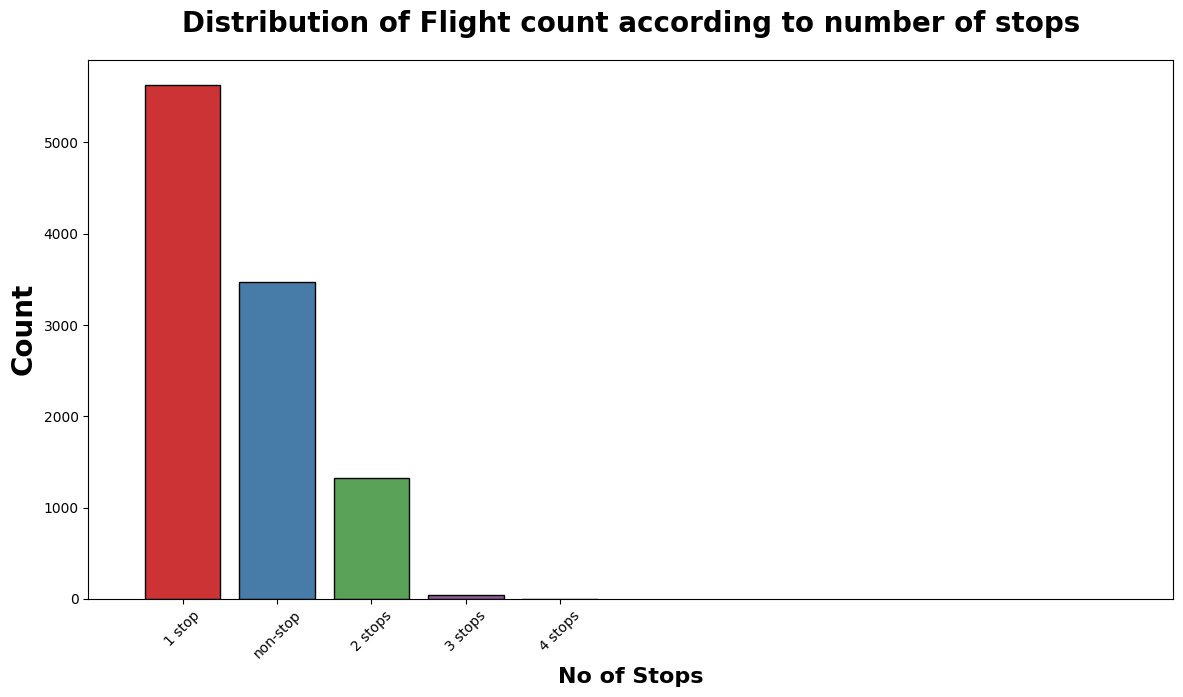

In [34]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Total_Stops", data=df,ec = "black",palette="Set1",order = df['Total_Stops'].value_counts().index)
plt.title("Distribution of Flight count according to number of stops", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("No of Stops", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

According to the count plot for No of Stops most of the Airlines have 1 stop and only few have 3 stops and 4 stops

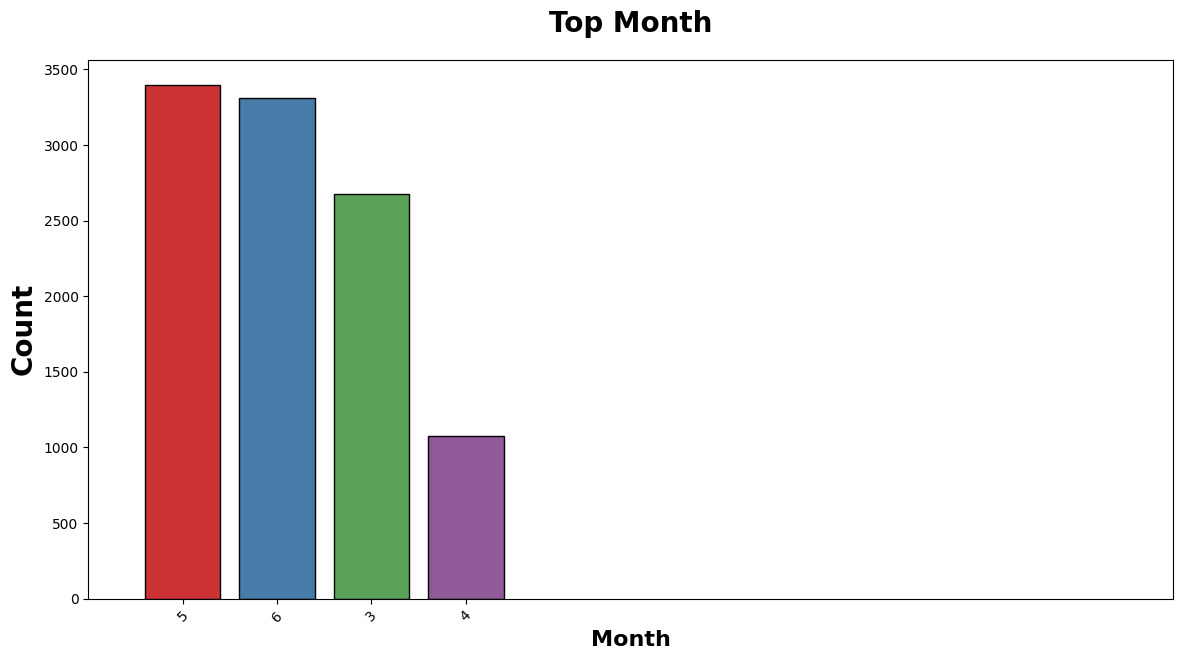

In [35]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Journey_month", data=df,ec = "black",palette="Set1",order = df['Journey_month'].value_counts().index)
plt.title("Top Month", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("Month", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

According to the count plot for journey_Month May Month is the Top month and March month is the Least Month.

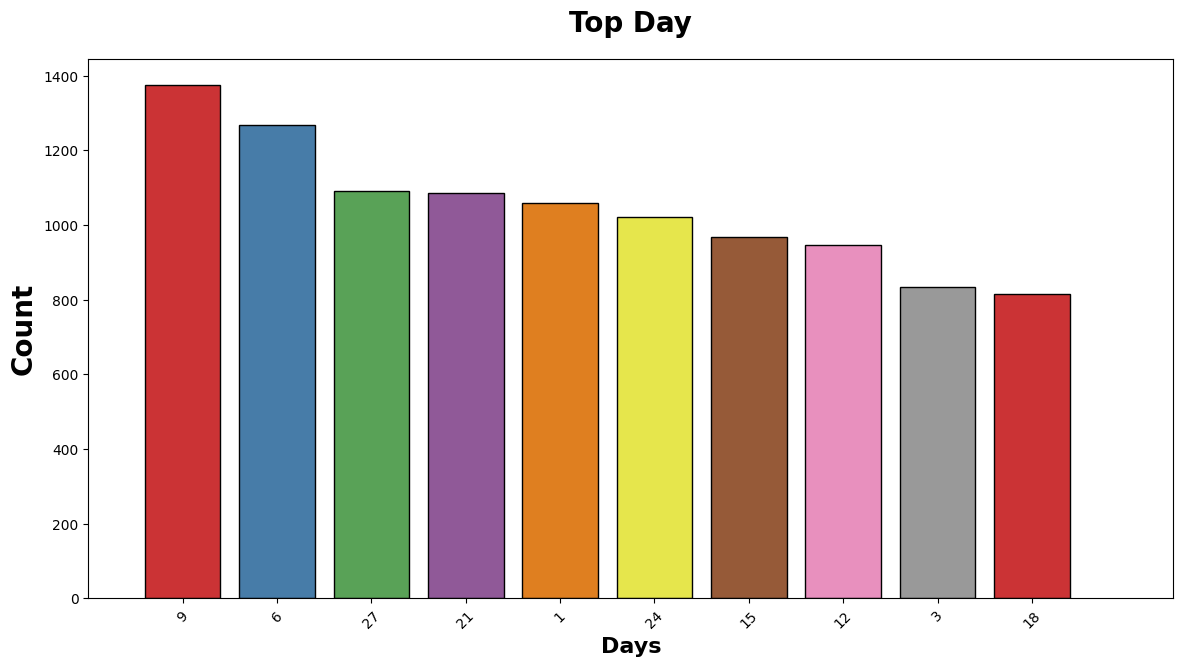

In [36]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Journey_day", data=df,ec = "black",palette="Set1",order = df['Journey_day'].value_counts().index)
plt.title("Top Day", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("Days", weight="bold", fontsize=16)
plt.xticks(rotation= 45)
plt.xlim(-1,10.5)
plt.show()

# **FEATURE VS TARGET **

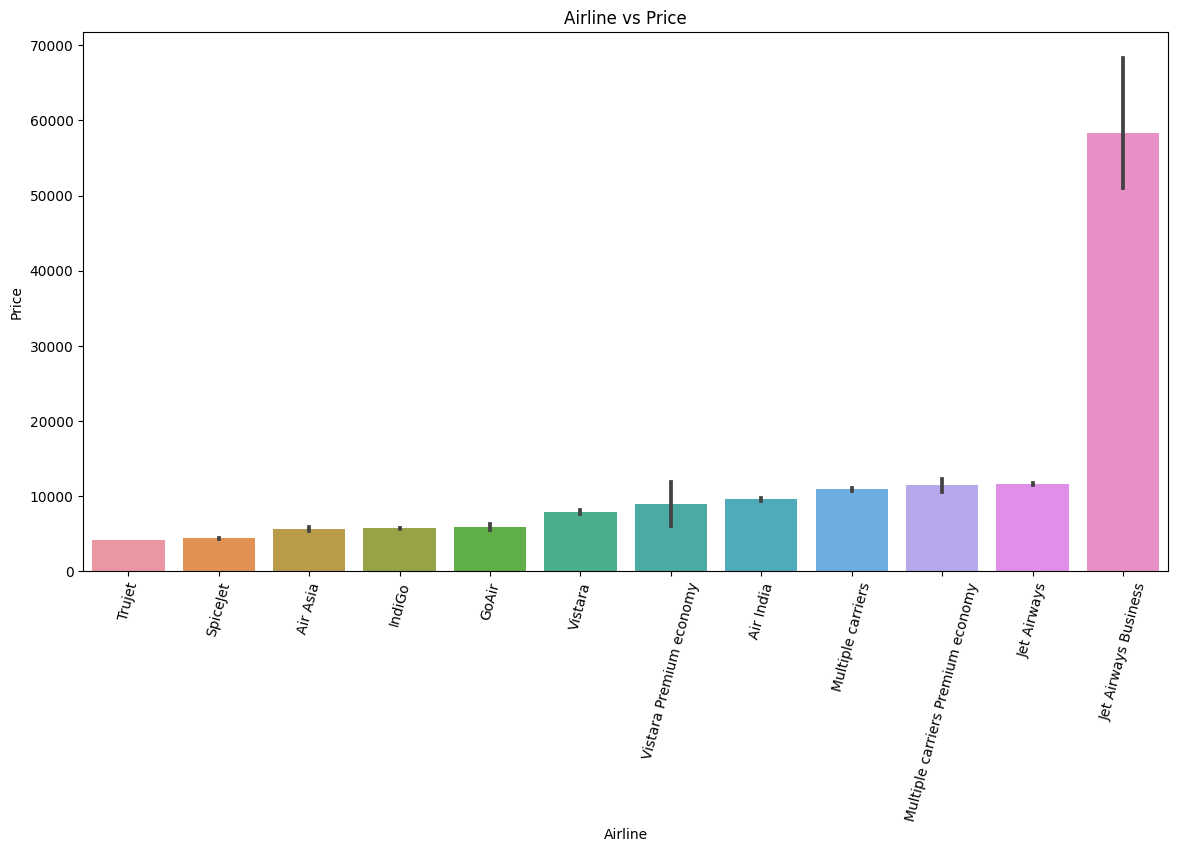

<Figure size 640x480 with 0 Axes>

In [37]:
plt.figure(figsize=(14,7))

sns.barplot(x='Airline',y='Price',data=df,order=df.groupby('Airline')['Price'].mean().reset_index().sort_values('Price')['Airline'])
plt.xticks(rotation=75)
plt.title('Airline vs Price')

plt.show()
plt.tight_layout()

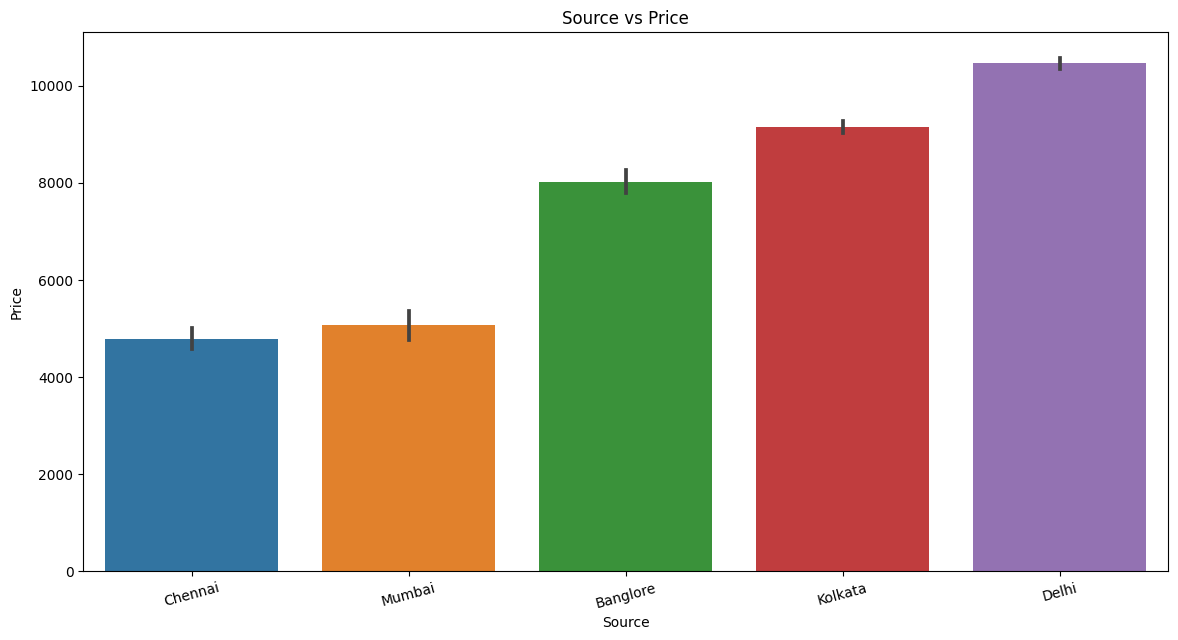

<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure(figsize=(14,7))
sns.barplot(x='Source',y='Price',data=df,order=df.groupby('Source')['Price'].mean().reset_index().sort_values('Price')['Source'])
plt.xticks(rotation=15)
plt.title('Source vs Price')
plt.show()
plt.tight_layout()

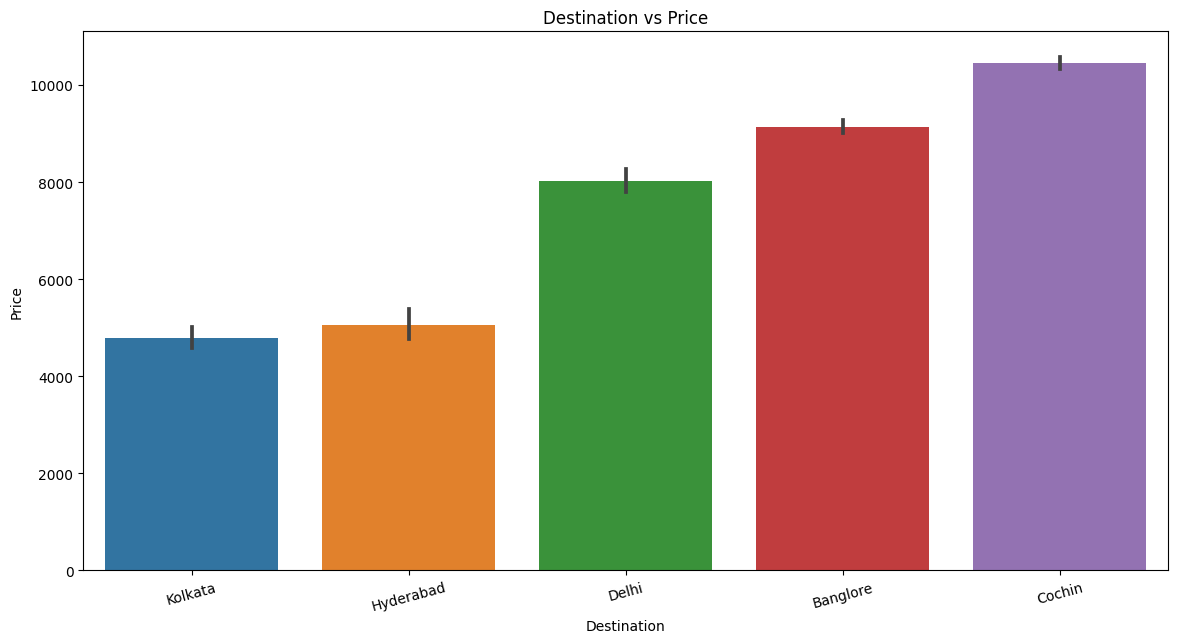

<Figure size 640x480 with 0 Axes>

In [39]:
plt.figure(figsize=(14,7))
sns.barplot(x='Destination',y='Price',data=df,order=df.groupby('Destination')['Price'].mean().reset_index().sort_values('Price')['Destination'])
plt.xticks(rotation=15)
plt.title('Destination vs Price')
plt.show()
plt.tight_layout()

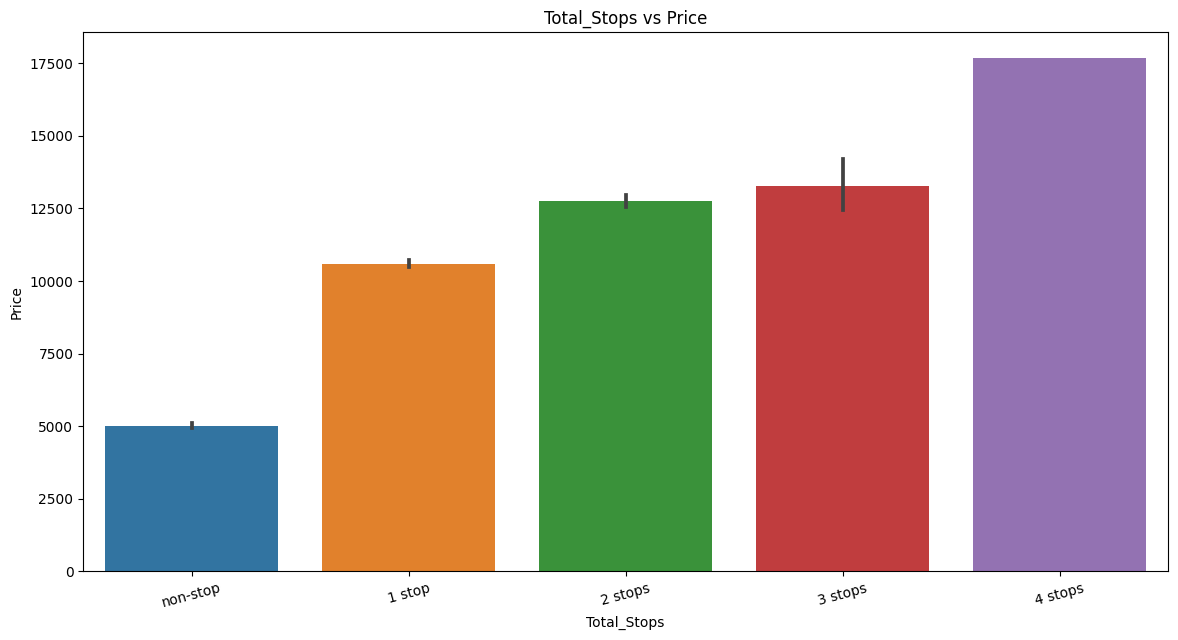

<Figure size 640x480 with 0 Axes>

In [40]:
plt.figure(figsize=(14,7))
sns.barplot(x='Total_Stops',y='Price',data=df,order=df.groupby('Total_Stops')['Price'].mean().reset_index().sort_values('Price')['Total_Stops'])
plt.xticks(rotation=15)
plt.title('Total_Stops vs Price')
plt.show()
plt.tight_layout()

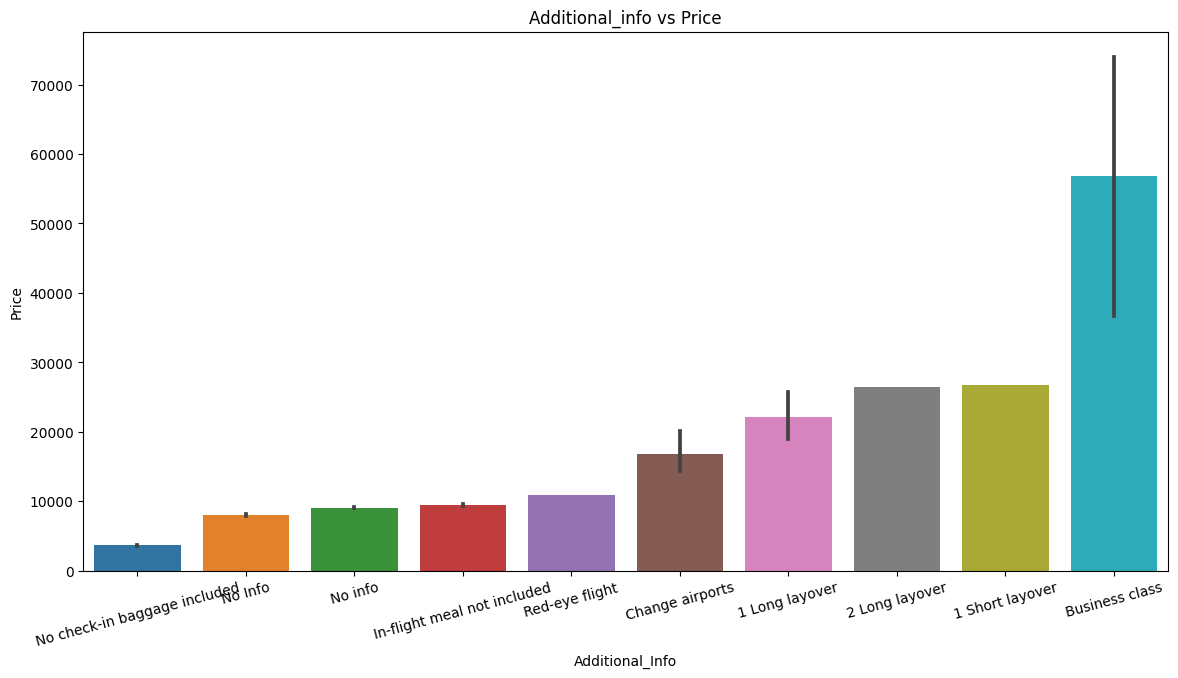

<Figure size 640x480 with 0 Axes>

In [41]:
plt.figure(figsize=(14,7))
sns.barplot(x='Additional_Info',y='Price',data=df,order=df.groupby('Additional_Info')['Price'].mean().reset_index().sort_values('Price')['Additional_Info'])
plt.xticks(rotation=15)
plt.title('Additional_info vs Price')
plt.show()
plt.tight_layout()

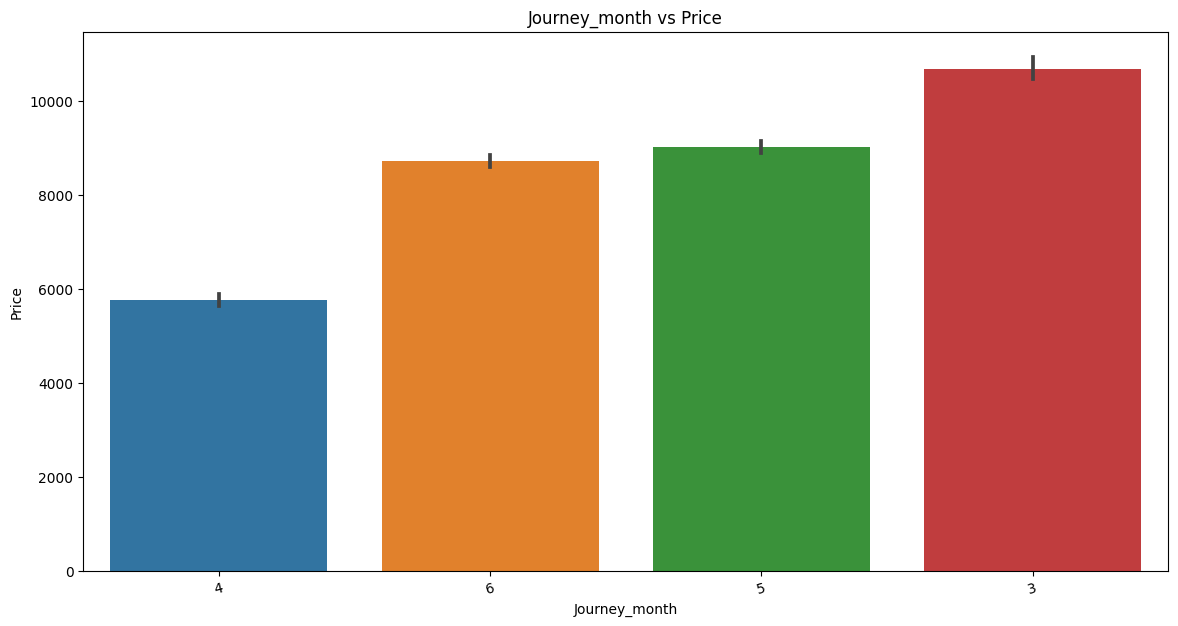

<Figure size 640x480 with 0 Axes>

In [42]:
plt.figure(figsize=(14,7))
sns.barplot(x='Journey_month',y='Price',data=df,order=df.groupby('Journey_month')['Price'].mean().reset_index().sort_values('Price')['Journey_month'])
plt.xticks(rotation=15)
plt.title('Journey_month vs Price')
plt.show()
plt.tight_layout()

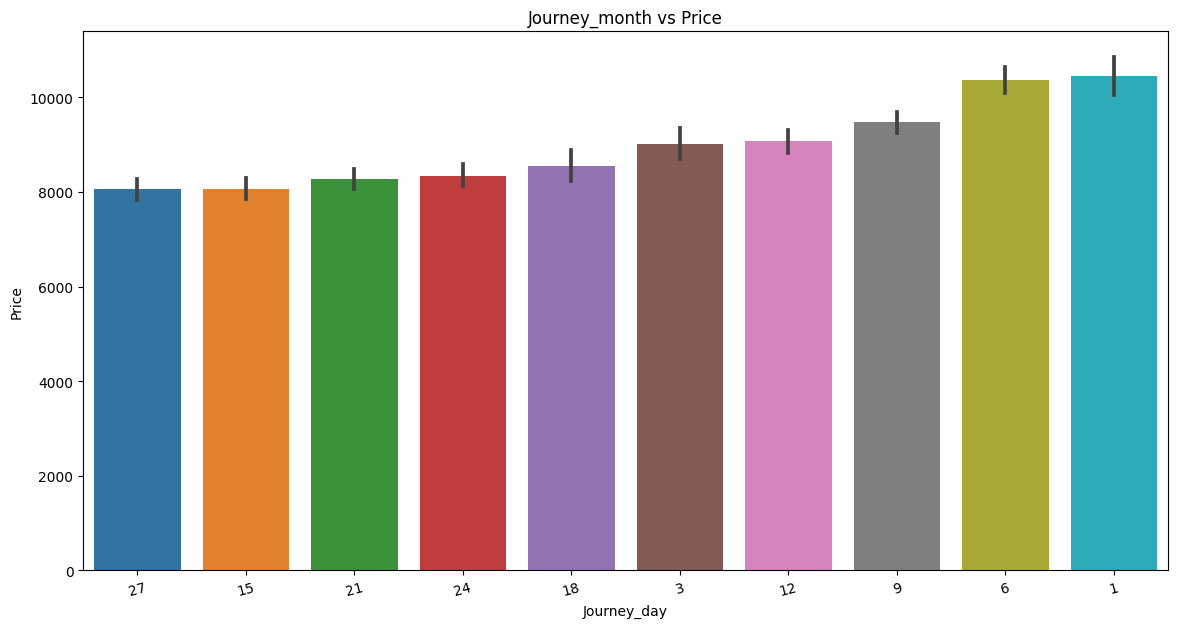

<Figure size 640x480 with 0 Axes>

In [43]:
plt.figure(figsize=(14,7))
sns.barplot(x='Journey_day',y='Price',data=df,order=df.groupby('Journey_day')['Price'].mean().reset_index().sort_values('Price')['Journey_day'])
plt.xticks(rotation=15)
plt.title('Journey_month vs Price')
plt.show()
plt.tight_layout()

# **INTERPRETATIONS**

1.) According to the "Airline vs Price" plot Jet Airway Business has the highest price and Trujet has the lowest price.

 2.) According to the  "Source vs Price" plot the ticket prices are high for city Delhi and low for city chennai

 3.) According to the "Destination vs Price" plot the ticket prices are high for city Cochin and low for city Kolkata.

 4.) According to the "Total_stops vs Price" plot when the no of stop increases the price also increases.

 5.) According to the "Additional_Info vs price" plot Business class has the highest price.
 
 6.) According to the "Journey_month vs Price" plot in 3rd Month the ticket prices are high.


In [44]:
# group data by airline name and get unique source and destination cities
grouped = df.groupby('Airline').agg({'Source': pd.Series.unique, 'Destination': pd.Series.unique})

# print the result
print(grouped)


                                                                        Source  \
Airline                                                                          
Air Asia                                            [Banglore, Kolkata, Delhi]   
Air India                          [Kolkata, Delhi, Chennai, Banglore, Mumbai]   
GoAir                                               [Delhi, Banglore, Kolkata]   
IndiGo                             [Banglore, Kolkata, Delhi, Chennai, Mumbai]   
Jet Airways                                 [Delhi, Banglore, Kolkata, Mumbai]   
Jet Airways Business                                         [Banglore, Delhi]   
Multiple carriers                                                      [Delhi]   
Multiple carriers Premium economy                                      [Delhi]   
SpiceJet                           [Kolkata, Delhi, Banglore, Chennai, Mumbai]   
Trujet                                                                [Mumbai]   
Vistara         

# **Ticket Prices Maximum and Minimum According to Airlines**

In [45]:
airline_price_stats = df.groupby('Airline')['Price'].describe()
airline_price_stats.sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
Airline,,,,,,,,
Jet Airways,3700.0,11599.021081,4315.671402,1840.0,8586.00,11134.0,14151.00,54826.0
IndiGo,2043.0,5668.469897,2266.933697,2227.0,4226.00,5000.0,6493.00,22153.0
Air India,1694.0,9556.608028,3937.875634,2050.0,6597.75,9316.0,12199.00,31945.0
Multiple carriers,1196.0,10902.678094,3721.234997,5797.0,7723.00,10197.0,13587.00,36983.0
SpiceJet,815.0,4335.841718,1851.144678,1759.0,3573.00,3873.0,4760.00,23267.0
Vistara,478.0,7801.355649,2915.288625,3687.0,5403.00,7980.0,9345.00,21730.0
Air Asia,319.0,5590.260188,2027.362290,3383.0,4282.00,5162.0,6451.00,13774.0
GoAir,194.0,5861.056701,2703.585767,3398.0,3898.00,5135.0,6811.25,22794.0
Multiple carriers Premium economy,13.0,11418.846154,1717.153936,9845.0,10161.00,11269.0,11269.00,14629.0


1.The JetAirways has a minimum price of 1840 and maximum price of 54826.

2.The IndiGo has a minimum price of 2227 and maximum price of 22153.

3.The AirIndia has a minimum price of 2050 and maximum price of 31945.

4.The SpiceJet has a minimum price of 1759 and maximum price of 23267.

5.The Multiple carriers has a minimum price of 5797 and maximum price of 36983.

6.The Vistara has a minimum price of 3687 and maximum price of 21730.

7.The AirAsia has a minimum price of 3383 and maximum price of 13774.

8.The GoAir has a minimum price of 3398 and maximum price of 22794.

9.The Multiple carriers Premium economy has a minimum price of 9845 and maximum price of 14629.

10.The Jet Airways Business has a minimum price of 46490 and maximum price of 79512.

11.The Vistara Premium economy has a minimum price of 5969 and maximum price of 11793.

12.The Trujet has a minimum price and maximum price as 4140




In [46]:
airline_price_stats = df.groupby('Source')['Price'].describe()
airline_price_stats.sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
Source,,,,,,,,
Delhi,4345.0,10461.600690,3817.751009,3876.0,7174.00,10262.0,13292.0,52285.0
Kolkata,2860.0,9143.083566,3739.618417,3480.0,5170.75,9345.0,12592.0,31945.0
Banglore,2179.0,8022.872877,5982.131784,3257.0,4544.00,6121.0,8714.0,79512.0
Mumbai,697.0,5059.708752,4100.504092,1759.0,2647.00,3342.0,5678.0,25139.0
Chennai,381.0,4789.892388,2190.219021,3145.0,3597.00,3850.0,5277.0,19630.0


<ipython-input-47-c2b066529135>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, cmap = "RdYlGn")


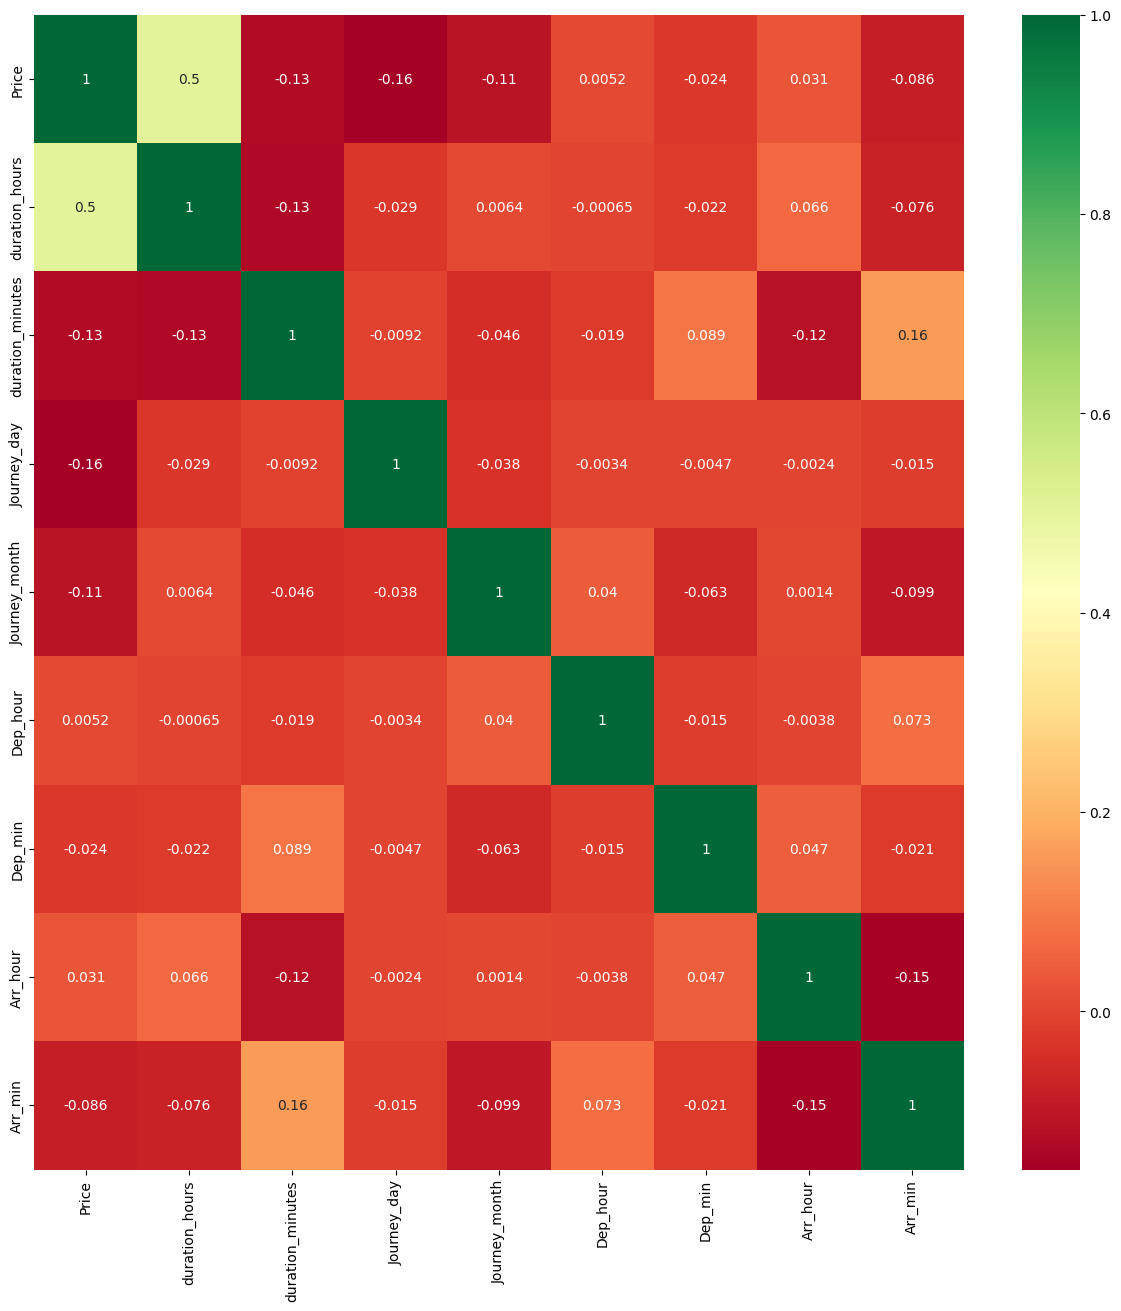

In [47]:
plt.figure(figsize = (15,15))
sns.heatmap(df.corr(), annot = True, cmap = "RdYlGn")
plt.show()

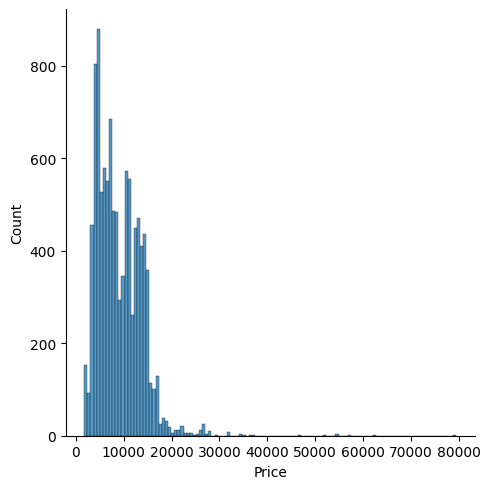

In [48]:
sns.displot(df['Price'])

Here we can see a few outliers having airfare more than 40000 and hence would reduce the accuracy of machine learning models, so it would be better to replace them with the median price of the entire dataset

In [49]:
df['Price']=np.where(df['Price']>40000,df['Price'].median(),df['Price'])

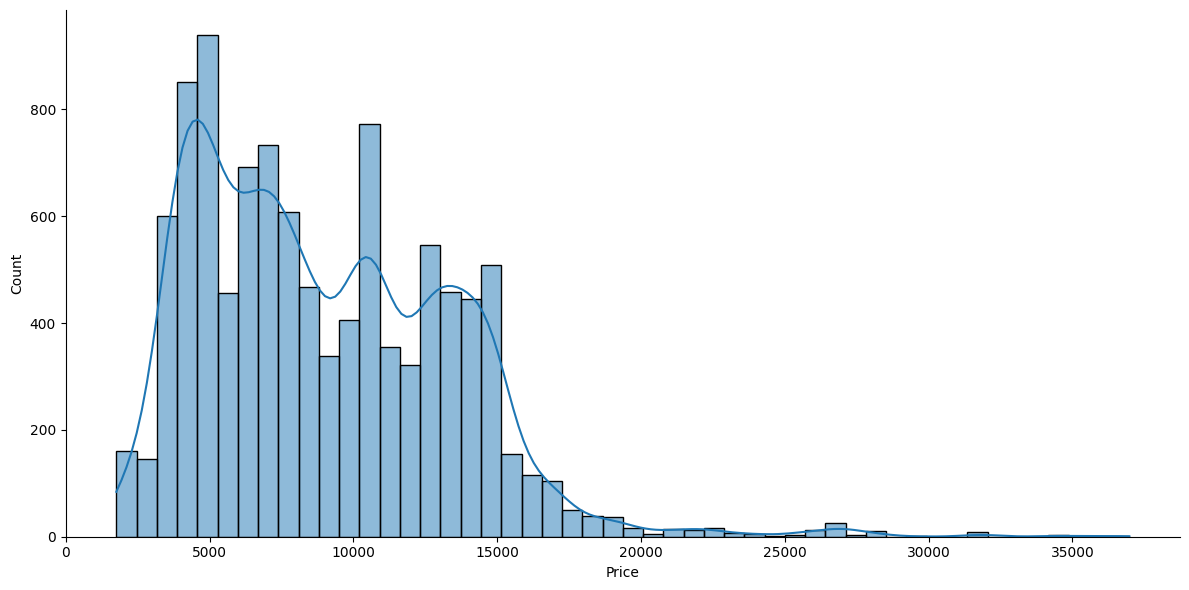

In [50]:
sns.displot(df['Price'],bins=50,aspect=2,height=6,kde=True)

# **ENCODING CATEGORICAL DATA**

# **Label Encoding**

In [51]:
df['Total_Stops'] = df['Total_Stops'].map({'1 stop':0,'non-stop':1,'2 stops':2,'3 stops':3,'4 stops':4})

# **One hot Encoding**

In [52]:
df= pd.get_dummies(df, columns=["Airline",'Destination','Source'])
df.head()

,Route,Duration,Total_Stops,Additional_Info,Price,duration_hours,duration_minutes,Journey_day,Journey_month,Dep_hour,...,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,BLR → DEL,2h 50m,1,No info,3897.0,2,50,24,3,22,...,0,0,1,0,0,1,0,0,0,0
1,CCU → IXR → BBI → BLR,7h 25m,2,No info,7662.0,7,25,1,5,5,...,1,0,0,0,0,0,0,0,1,0
2,DEL → LKO → BOM → COK,19h 0m,2,No info,13882.0,19,0,9,6,9,...,0,1,0,0,0,0,0,1,0,0
3,CCU → NAG → BLR,5h 25m,0,No info,6218.0,5,25,12,5,18,...,1,0,0,0,0,0,0,0,1,0
4,BLR → NAG → DEL,4h 45m,0,No info,13302.0,4,45,1,3,16,...,0,0,1,0,0,1,0,0,0,0


In [53]:
df=df.drop(['Additional_Info','Route'],axis=1)

# **FEATURE SELECTION**

1.featureimportance

2.SelectKBest

In [54]:
#dropping the duration column
df.drop('Duration',axis=1,inplace=True)

In [55]:
X= df.drop(['Price',],axis=1)
y=df['Price']

In [56]:
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [57]:
print(selection.feature_importances_)

[1.16736111e-01 1.90684072e-01 1.72970848e-02 1.51854557e-01
 7.20811878e-02 2.38518345e-02 2.26023292e-02 2.16660157e-02
 2.01112570e-02 1.91366349e-03 2.67540859e-02 1.68083635e-03
 9.53971536e-03 1.71235630e-01 2.20755201e-04 2.64027429e-02
 1.07840145e-03 2.67985603e-03 6.39771233e-05 6.65139348e-03
 8.88445096e-05 3.44685585e-03 2.89327524e-02 1.39092491e-02
 1.84393242e-02 6.81847585e-04 1.28162324e-02 6.34229976e-04
 1.84677753e-02 3.41194408e-03 1.40654376e-02]


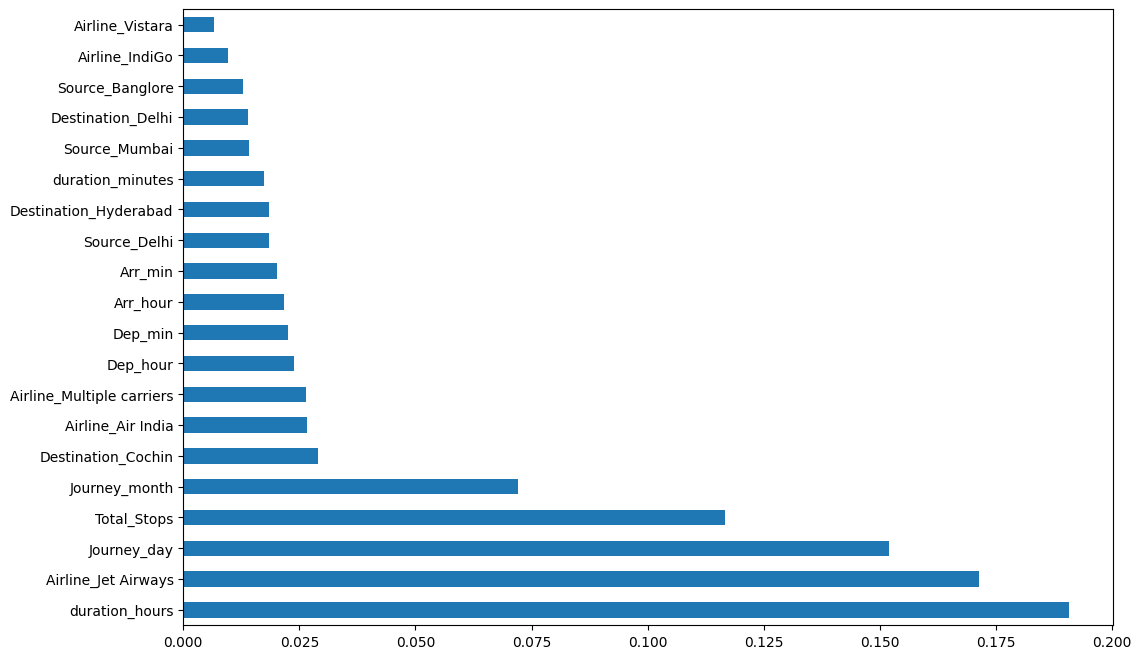

In [58]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0)

In [60]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(8369, 31) (2093, 31) (8369,) (2093,)


# **Building Machine Learning Models**

#  1.Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression(fit_intercept=True)
LR.fit(X_train,y_train)
LR.predict(X_test)

array([ 8823.25985602,  4204.81573019, 11043.53729577, ...,
       11884.81782575, 13316.73714182, 10358.53429035])

In [62]:
from sklearn.model_selection import cross_val_score
cross_val_linear_model=cross_val_score(LR,X_train,y_train,cv=10).mean()
cross_val_linear_model

0.5283300988265531

In [63]:
y_pred_lr=LR.predict(X_test)

In [64]:
print("MAE:",metrics.mean_absolute_error(y_test,y_pred_lr))
print("MSE:",metrics.mean_squared_error(y_test,y_pred_lr))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_lr)))

MAE: 2187.004758207571
MSE: 9601156.13325408
RMSE: 3098.573241550711


<ipython-input-65-8200b7b54c6f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred_lr)


<Axes: xlabel='Price', ylabel='Density'>

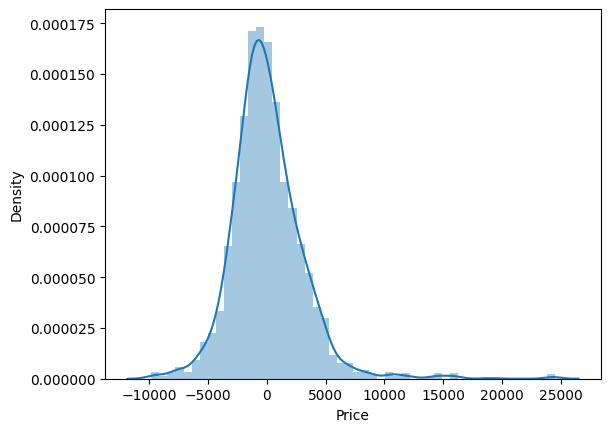

In [65]:
sns.distplot(y_test-y_pred_lr)

#  2.K Nearest Neighbor Regression

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_values=np.arange(1,20)
cross_val_knn=[]
for k in knn_values:
  knn_regressor=KNeighborsRegressor(n_neighbors=k)
  knn_regressor.fit(X_train_scaled,y_train)
  print("K value : ", k, " train score : ", knn_regressor.score(X_train_scaled,y_train)  ,"cross_val_score : ", cross_val_score(knn_regressor,X_train_scaled,y_train,cv = 10).mean())
  cross_val_knn.append(cross_val_score(knn_regressor,X_train_scaled,y_train,cv = 10).mean())

K value :  1  train score :  0.9339790942299887 cross_val_score :  0.624448955047292
K value :  2  train score :  0.9081558692817445 cross_val_score :  0.7213978653074686
K value :  3  train score :  0.8752295134177741 cross_val_score :  0.7406039398342812
K value :  4  train score :  0.85306142374113 cross_val_score :  0.7464693350888447
K value :  5  train score :  0.8377311598438542 cross_val_score :  0.7469427355078159
K value :  6  train score :  0.8259172889478728 cross_val_score :  0.7465249347995743
K value :  7  train score :  0.8167287430493986 cross_val_score :  0.7433915050440111
K value :  8  train score :  0.8072076419701819 cross_val_score :  0.7393184487843253
K value :  9  train score :  0.7987394107853474 cross_val_score :  0.7359391730423657
K value :  10  train score :  0.7905356427153679 cross_val_score :  0.731440558157755
K value :  11  train score :  0.7832817860615049 cross_val_score :  0.7269943928241875
K value :  12  train score :  0.7766697317353912 cross_v

In [67]:
knn_regressor=KNeighborsRegressor(n_neighbors=6)
knn_regressor.fit(X_train_scaled,y_train)

KNeighborsRegressor(n_neighbors=6)

In [68]:
cross_val_knn_regressor=cross_val_score(knn_regressor,X_train_scaled,y_train,cv=15).mean()
cross_val_knn_regressor

0.7482065013214664

In [69]:
y_pred_knn=knn_regressor.predict(X_test_scaled)
print("MAE:",metrics.mean_absolute_error(y_test,y_pred_knn))
print("MSE:",metrics.mean_squared_error(y_test,y_pred_knn))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_knn)))

MAE: 1413.430402930403
MSE: 5031736.637083931
RMSE: 2243.153279890594


# **3.Decision Tree Regression**

In [70]:
from sklearn.tree import DecisionTreeRegressor

max_depth=np.arange(1,20)
cross_val_dt=[]
for d in max_depth:
  dt_regressor= DecisionTreeRegressor(max_depth=d, random_state=0)
  dt_regressor.fit(X_train,y_train)
  print("Depth : ", d, " train Score  : ", dt_regressor.score(X_train,y_train), "cross_val_score : ", cross_val_score(dt_regressor,X_train,y_train,cv = 15).mean())
  cross_val_dt.append(cross_val_score(dt_regressor,X_train,y_train,cv = 15).mean())

Depth :  1  train Score  :  0.4245125698813267 cross_val_score :  0.42503150616461755
Depth :  2  train Score  :  0.5019767193736133 cross_val_score :  0.5021030220305557
Depth :  3  train Score  :  0.5611674676174557 cross_val_score :  0.5608971707762891
Depth :  4  train Score  :  0.6569251586088376 cross_val_score :  0.6520291224860848
Depth :  5  train Score  :  0.7064082520512087 cross_val_score :  0.6918465535806374
Depth :  6  train Score  :  0.7588509543017948 cross_val_score :  0.7365661395639252
Depth :  7  train Score  :  0.7856175229785104 cross_val_score :  0.7493440722292767
Depth :  8  train Score  :  0.8156949299495108 cross_val_score :  0.767552003711817
Depth :  9  train Score  :  0.8386707849101266 cross_val_score :  0.7778303572813593
Depth :  10  train Score  :  0.8631686487836933 cross_val_score :  0.7841091199696069
Depth :  11  train Score  :  0.8831043571966742 cross_val_score :  0.7822253655387398
Depth :  12  train Score  :  0.905264487294933 cross_val_score 

In [71]:
cross_val_dt_regressor=max(cross_val_dt)

In [72]:
print("The best depth is 10 and Cross_val_score is:",cross_val_dt_regressor)

The best depth is 10 and Cross_val_score is: 0.7841091199696069


In [73]:
dt_regressor=DecisionTreeRegressor(max_depth=10, random_state=0)
dt_regressor.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [74]:
cross_val_dt_regressor=cross_val_score(dt_regressor,X_train,y_train,cv=15).mean()
cross_val_dt_regressor

0.7841091199696069

In [75]:
y_pred_dt= dt_regressor.predict(X_test)
print("MAE:",metrics.mean_absolute_error(y_test,y_pred_dt))
print("MSE:",metrics.mean_squared_error(y_test,y_pred_dt))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_dt)))

MAE: 1352.2186129815498
MSE: 4188292.5843021814
RMSE: 2046.531842972931


# **4.Random Forest Regression**

In [76]:
max_depth=np.array([2,4,8,10,13,15,20])
cross_val_rf=[]
for d in max_depth:
  rf_regressor=RandomForestRegressor(max_depth=d, random_state=0)
  rf_regressor.fit(X_train,y_train)
  print("Depth : ", d, "cross_val_score : ", cross_val_score(rf_regressor,X_train,y_train,cv = 15).mean())
  cross_val_rf.append(cross_val_score(rf_regressor,X_train,y_train,cv = 15).mean())

Depth :  2 cross_val_score :  0.5051298493492747
Depth :  4 cross_val_score :  0.6665700168313785
Depth :  8 cross_val_score :  0.8068202976601861
Depth :  10 cross_val_score :  0.8287738449653109
Depth :  13 cross_val_score :  0.8336025736178746
Depth :  15 cross_val_score :  0.8270633617886943
Depth :  20 cross_val_score :  0.8140126125515555


In [77]:
cross_val_rf_regressor=max(cross_val_rf)

In [78]:
print("The best depth is  13 and Cross_val_score is:",cross_val_rf_regressor)

The best depth is  13 and Cross_val_score is: 0.8336025736178746


In [79]:
rf_regressor=RandomForestRegressor(max_depth=13, random_state=0)
rf_regressor.fit(X_train,y_train)

RandomForestRegressor(max_depth=13, random_state=0)

In [80]:
cross_val_rf_regressor=cross_val_score(rf_regressor,X_train,y_train,cv=15).mean()
cross_val_rf_regressor

0.8336025736178746

In [81]:
y_pred_dt= rf_regressor.predict(X_test)
print("MAE:",metrics.mean_absolute_error(y_test,y_pred_dt))
print("MSE:",metrics.mean_squared_error(y_test,y_pred_dt))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_dt)))

MAE: 1179.4427810467405
MSE: 3446603.2629763307
RMSE: 1856.5029660564323


# **5.Extreme Gradient Boosting Regression**

In [82]:
cross_val_xgb=[]
for lr in [0.01,0.05,0.1]:
  xgb_regressor= xgb.XGBRegressor(colsample_bytree=0.4,learning_rate = lr,n_estimators=1000) 
  xgb_regressor.fit(X_train,y_train) 
  print("Learning rate : ", lr,"cross_val_score:", cross_val_score(xgb_regressor,X_train,y_train,cv = 15).mean())
  cross_val_xgb.append(cross_val_score(xgb_regressor,X_train,y_train,cv = 15).mean())

Learning rate :  0.01 cross_val_score: 0.8295110499404564
Learning rate :  0.05 cross_val_score: 0.8482688013675695
Learning rate :  0.1 cross_val_score: 0.8376995049844154


In [83]:
cross_val_xgb_regressor=max(cross_val_xgb)

In [84]:
print("The best Learning rate is 0.05 and Cross_val_score is:",cross_val_xgb_regressor)


The best Learning rate is 0.05 and Cross_val_score is: 0.8482688013675695


In [85]:
xgb_regressor= xgb.XGBRegressor(learning_rate =0.05,n_estimators=100) # initialise the model
xgb_regressor.fit(X_train,y_train) #train the model


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [86]:
cross_val_xgb_regressor=cross_val_score(xgb_regressor,X_train,y_train,cv=15).mean()
cross_val_xgb_regressor

0.8213908646864617

In [87]:
y_pred_xgb= xgb_regressor.predict(X_test)
print("MAE:",metrics.mean_absolute_error(y_test,y_pred_xgb))
print("MSE:",metrics.mean_squared_error(y_test,y_pred_xgb))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgb)))

MAE: 1312.7573673778668
MSE: 3644263.446668347
RMSE: 1908.995402474387


In [88]:
print("Cross Validation Score for Linear Regression Model:",cross_val_linear_model)
print("Cross Validation Score for K-Nearest Neighbors Regression Model:",cross_val_knn_regressor)
print("Cross Validation Score for Decision Tree Regression Model: ",cross_val_dt_regressor)
print("Cross Validation Score for Random Forest Regression Model: ",cross_val_rf_regressor)
print("Cross Validation Score for Extreme-Gradient Boosting Regression Model: ",cross_val_xgb_regressor)

Cross Validation Score for Linear Regression Model: 0.5283300988265531
Cross Validation Score for K-Nearest Neighbors Regression Model: 0.7482065013214664
Cross Validation Score for Decision Tree Regression Model:  0.7841091199696069
Cross Validation Score for Random Forest Regression Model:  0.8336025736178746
Cross Validation Score for Extreme-Gradient Boosting Regression Model:  0.8213908646864617


In [89]:
from sklearn.metrics import r2_score
y_pred_lr=LR.predict(X_test)
y_pred_knn=knn_regressor.predict(X_test_scaled)
y_pred_dt= dt_regressor.predict(X_test)
y_pred_rf=rf_regressor.predict(X_test)
y_pred_xgb=xgb_regressor.predict(X_test)

In [90]:
R2_score_knn=r2_score(y_test,y_pred_knn)
R2_score_lr=r2_score(y_test,y_pred_lr)
R2_score_dt=r2_score(y_test,y_pred_dt)
R2_score_rf=r2_score(y_test,y_pred_rf)
R2_score_xgb=r2_score(y_test,y_pred_xgb)

In [91]:
print("R2 Score for Linear Regression Model:",R2_score_lr)
print("R2 Score for K-Nearest Neighbors Regression Model:",R2_score_knn)
print("R2 Score for Decision Tree Regression Model: ",R2_score_dt)
print("R2 Score for Random Forest Regression Model: ",R2_score_rf)
print("R2 Score for Extreme-Gradient Boosting Regression Model: ",R2_score_xgb)

R2 Score for Linear Regression Model: 0.5216300686411854
R2 Score for K-Nearest Neighbors Regression Model: 0.7492977432831656
R2 Score for Decision Tree Regression Model:  0.7913216691556696
R2 Score for Random Forest Regression Model:  0.8282757468529731
R2 Score for Extreme-Gradient Boosting Regression Model:  0.8184274861651143


In [92]:
metrics_list = [    {"Model": "Linear Regression", "Mean Squared Error": 9601156.13, "Mean Absolute Error": 2187.01, "RMSE": 3098.57, "R2 Score": 0.52},    {"Model": "K Neighbors", "Mean Squared Error": 5031736.63, "Mean Absolute Error": 1413.43, "RMSE": 2243.15, "R2 Score": 0.75},    {"Model": "Decision Tree Regression", "Mean Squared Error": 4188292.58, "Mean Absolute Error": 1352.21, "RMSE": 2046.53, "R2 Score": 0.79},{"Model": "Random Forest Regression", "Mean Squared Error": 3446603.26, "Mean Absolute Error": 1179.44, "RMSE": 1856.50, "R2 Score": 0.83},{"Model": "Extreme-Gradient Boosting Regression", "Mean Squared Error":3644263.45, "Mean Absolute Error": 1312.75, "RMSE": 1908.96, "R2 Score": 0.81}]


In [93]:
df_metrics = pd.DataFrame(metrics_list)

In [94]:
df_metrics

,Model,Mean Squared Error,Mean Absolute Error,RMSE,R2 Score
0,Linear Regression,9601156.13,2187.01,3098.57,0.52
1,K Neighbors,5031736.63,1413.43,2243.15,0.75
2,Decision Tree Regression,4188292.58,1352.21,2046.53,0.79
3,Random Forest Regression,3446603.26,1179.44,1856.50,0.83
4,Extreme-Gradient Boosting Regression,3644263.45,1312.75,1908.96,0.81


# **FEATURE IMPORTANCE OF ALL MODELS**


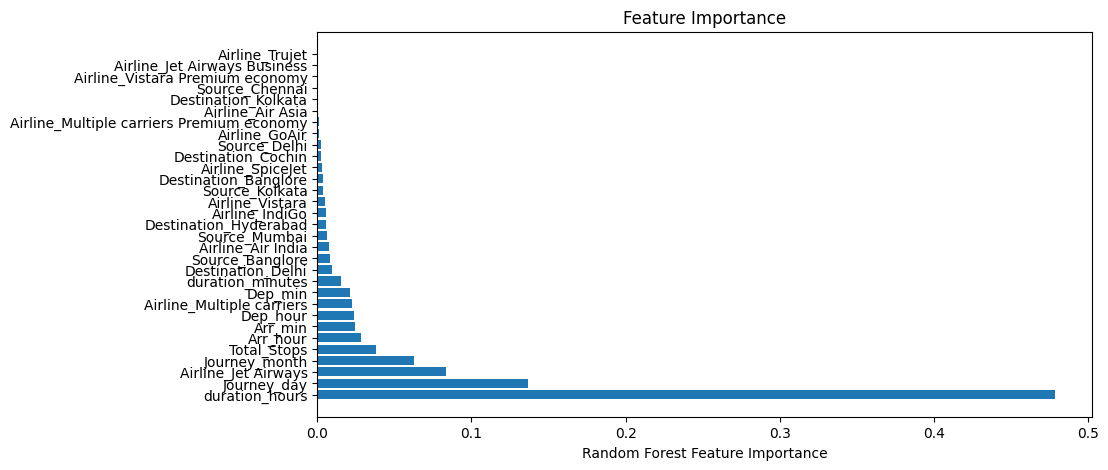

In [95]:
importance = ['Total_Stops', 'duration_hours', 'duration_minutes', 'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min', 'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai']

importance_values = rf_regressor.feature_importances_
sorted_indices = np.argsort(importance_values)[::-1] # get the sorted indices in descending order
importance_sorted = [importance[i] for i in sorted_indices] # sort the importance list based on the sorted indices
importance_values_sorted = importance_values[sorted_indices] # sort the importance values based on the sorted indices

plt.figure(figsize=(10,5))
plt.barh(importance_sorted, importance_values_sorted)
plt.xlabel("Random Forest Feature Importance")
plt.title("Feature Importance")
plt.show()


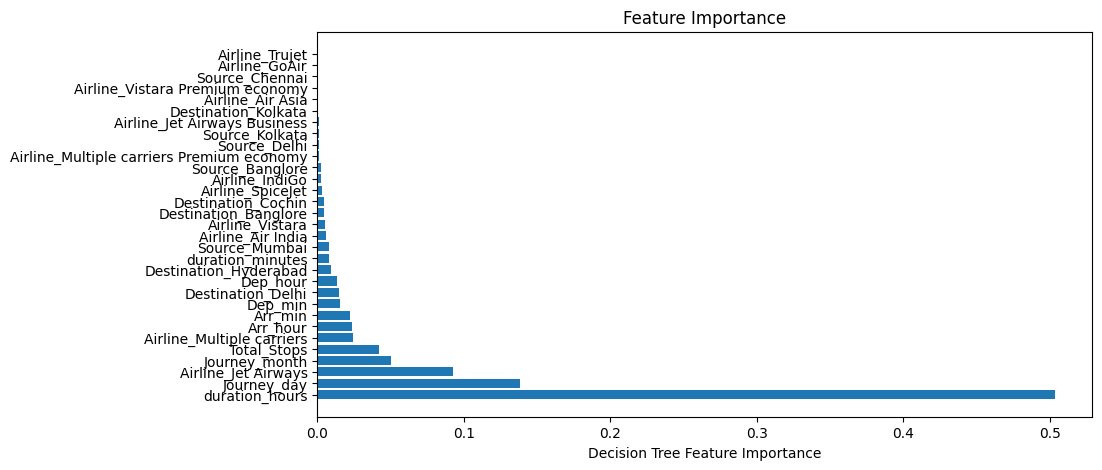

In [96]:
importance = ['Total_Stops', 'duration_hours', 'duration_minutes', 'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min', 'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai']

importance_values = dt_regressor.feature_importances_
sorted_indices = np.argsort(importance_values)[::-1] # get the sorted indices in descending order
importance_sorted = [importance[i] for i in sorted_indices] # sort the importance list based on the sorted indices
importance_values_sorted = importance_values[sorted_indices] # sort the importance values based on the sorted indices

plt.figure(figsize=(10,5))
plt.barh(importance_sorted, importance_values_sorted)
plt.xlabel("Decision Tree Feature Importance")
plt.title("Feature Importance")
plt.show()


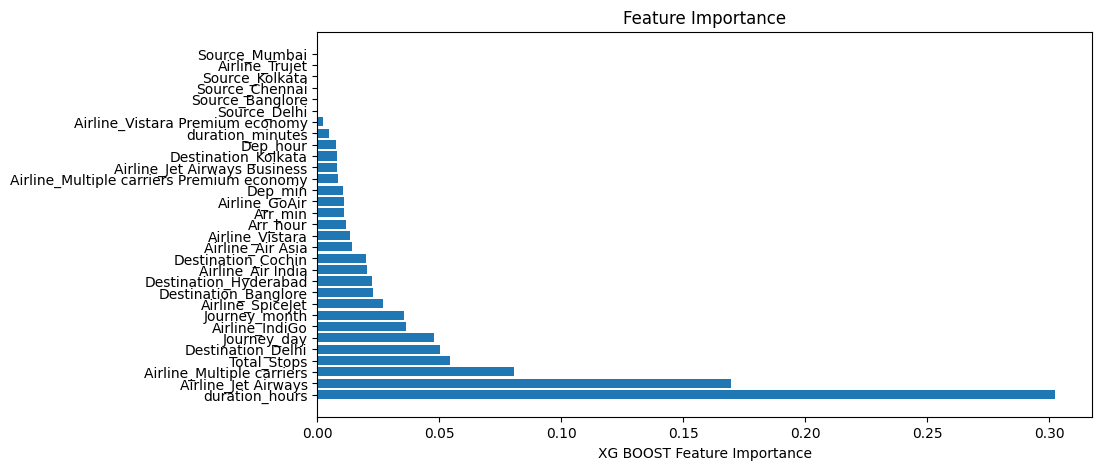

In [97]:
importance = ['Total_Stops', 'duration_hours', 'duration_minutes', 'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min', 'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai']

importance_values = xgb_regressor.feature_importances_
sorted_indices = np.argsort(importance_values)[::-1] # get the sorted indices in descending order
importance_sorted = [importance[i] for i in sorted_indices] # sort the importance list based on the sorted indices
importance_values_sorted = importance_values[sorted_indices] # sort the importance values based on the sorted indices

plt.figure(figsize=(10,5))
plt.barh(importance_sorted, importance_values_sorted)
plt.xlabel("XG BOOST Feature Importance")
plt.title("Feature Importance")
plt.show()

# **BUSINESS INTERPRETATIONS**

# IMPORTANT FEATURES FOR MAKING PREDICTIONS:

1.**Duration Of the flight**:As the Duration of the flight increases the price also increases.

2.**Journey_day**:We can see the journey day plays an important role,the prices are high on the weekends than the week days.

3.**Total_stops**:The flights with more stops are high priced when compared to the flights no stops

At the end of these analysis, we came to know that customers choose the right day and non stop flights and flights with less duration,so that they can get the flights at cheapest price.